In [524]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_f15951a462a94810bc60e89283900cad(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', 'f8ad0f3da24b49ddb42b702d93bda378')
    hconf.set(prefix + '.username', '47c0822f6f47447d9b91f4d987c98cb5')
    hconf.set(prefix + '.password', 'ew[iAL9XqDs8O*^S')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_f15951a462a94810bc60e89283900cad(name)

df_data_1 = sqlContext.read.format('com.databricks.spark.csv')\
  .options(header='true', inferschema='true')\
  .load("swift://CS3401." + name + "/triangles.csv")

In [525]:
#creating main rdd
coordinates = sc.textFile(("swift://CS3401." + name + "/triangles.csv"))

In [526]:
### PART 1 ###

In [527]:
#function that checks triangle inequality
def isTriangle(coordinateTriplets):
    x1 = int(coordinateTriplets.split(",")[0].split(" ")[0])
    y1 = int(coordinateTriplets.split(",")[0].split(" ")[1])
    x2 = int(coordinateTriplets.split(",")[1].split(" ")[1])
    y2 = int(coordinateTriplets.split(",")[1].split(" ")[2])
    x3 = int(coordinateTriplets.split(",")[2].split(" ")[1])
    y3 = int(coordinateTriplets.split(",")[2].split(" ")[2])

    a = ((x1 - x3) ** 2 + (y1 - y3) ** 2) ** (0.5)
    b = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (0.5)
    c = ((x2 - x3) ** 2 + (y2 - y3) ** 2) ** (0.5)

    sides = [a, b, c]
    small, mid, big = sorted(sides)
    if small==0:
        return False
    elif mid==0:
        return False
    elif big==0:
        return False
    else:
        return small + mid > big

In [528]:
#filtering rdd based on triangle inequality
valid_triangles = coordinates.filter(isTriangle)

In [529]:
#sample of valid triangles
valid_triangles.take(10)

[u'13 27, 68 55, 12 62',
 u'64 96, 91 62, 43 51',
 u'28 44, 93 59, 68 4',
 u'60 8, 87 65, 93 98',
 u'4 65, 2 77, 18 85',
 u'82 50, 79 69, 11 68',
 u'58 10, 4 20, 39 11',
 u'76 0, 61 93, 29 94',
 u'63 87, 79 96, 15 35',
 u'32 56, 90 4, 89 26']

In [530]:
#counting the valid triangles
number_of_valid_triangles = valid_triangles.count()
print "There is "+str(number_of_valid_triangles)+" valid triangles in this dataset."

There is 999074 valid triangles in this dataset.


In [531]:
### PART 2 ###

In [532]:
#function that returns first coordinate.
def vertex1(coordinateTriplets):
    x1 = int(coordinateTriplets.split(",")[0].split(" ")[0])
    y1 = int(coordinateTriplets.split(",")[0].split(" ")[1])   
    return (x1,y1)

In [533]:
#function that returns second coordinate.
def vertex2(coordinateTriplets):
    x2 = int(coordinateTriplets.split(",")[1].split(" ")[1])
    y2 = int(coordinateTriplets.split(",")[1].split(" ")[2])
    return (x2,y2)

In [534]:
#function that returns third coordinate.
def vertex3(coordinateTriplets):    
    x3 = int(coordinateTriplets.split(",")[2].split(" ")[1])
    y3 = int(coordinateTriplets.split(",")[2].split(" ")[2])
    return (x3,y3)

In [535]:
vertexes1 = (valid_triangles.map(vertex1))

In [536]:
vertexes2 = (valid_triangles.map(vertex2))

In [537]:
vertexes3 = (valid_triangles.map(vertex3))

In [538]:
#creating dictionary of coordinate and its frequency
vertexes = vertexes1.union(vertexes2).union(vertexes3).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).collectAsMap()

In [539]:
#function that returns triangle and it's total neighbours
def neighbours(coordinateTriplets):
    x1 = int(coordinateTriplets.split(",")[0].split(" ")[0])
    y1 = int(coordinateTriplets.split(",")[0].split(" ")[1])
    x2 = int(coordinateTriplets.split(",")[1].split(" ")[1])
    y2 = int(coordinateTriplets.split(",")[1].split(" ")[2])
    x3 = int(coordinateTriplets.split(",")[2].split(" ")[1])
    y3 = int(coordinateTriplets.split(",")[2].split(" ")[2])
    
    v1 = (x1,y1)
    v2 = (x2,y2)
    v3 = (x3,y3)
    
    v1_count = vertexes[v1]
    v2_count = vertexes[v2]
    v3_count = vertexes[v3]
    
    v_count = (v1_count + v2_count + v3_count) - 3
    
    return (coordinateTriplets,v_count)

In [540]:
neighbours_rdd = valid_triangles.map(neighbours)

In [541]:
#sample of total neighbours of some triangles
neighbours_rdd.take(10)

[(u'13 27, 68 55, 12 62', 902),
 (u'64 96, 91 62, 43 51', 902),
 (u'28 44, 93 59, 68 4', 897),
 (u'60 8, 87 65, 93 98', 901),
 (u'4 65, 2 77, 18 85', 898),
 (u'82 50, 79 69, 11 68', 903),
 (u'58 10, 4 20, 39 11', 868),
 (u'76 0, 61 93, 29 94', 922),
 (u'63 87, 79 96, 15 35', 846),
 (u'32 56, 90 4, 89 26', 837)]

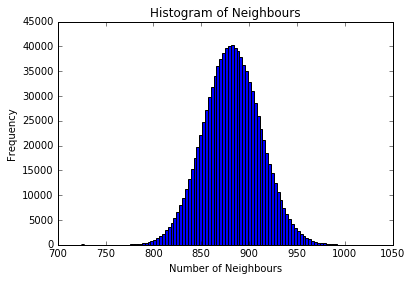

In [542]:
%matplotlib inline
import matplotlib.pyplot as plt
bins = 100
plt.hist(neighbours_rdd.values().collect(), bins, histtype='bar',rwidth=1.2)

plt.xlabel('Number of Neighbours')
plt.ylabel('Frequency')
plt.title('Histogram of Neighbours')
plt.show()

In [543]:
mean = neighbours_rdd.values().sum()/neighbours_rdd.count()
print "The mean of the number of neighbours is "+str(mean)+"."

The mean of the number of neighbours is 881.


In [544]:
##PART 3

In [545]:
#function that finds circumferences of triangle
def circumferences(coordinateTriplets):
    x1 = int(coordinateTriplets.split(",")[0].split(" ")[0])
    y1 = int(coordinateTriplets.split(",")[0].split(" ")[1])
    x2 = int(coordinateTriplets.split(",")[1].split(" ")[1])
    y2 = int(coordinateTriplets.split(",")[1].split(" ")[2])
    x3 = int(coordinateTriplets.split(",")[2].split(" ")[1])
    y3 = int(coordinateTriplets.split(",")[2].split(" ")[2])
    
    a = ((x1 - x3) ** 2 + (y1 - y3) ** 2) ** (0.5)
    b = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (0.5)
    c = ((x2 - x3) ** 2 + (y2 - y3) ** 2) ** (0.5)
    
    circum = a + b + c
    return (coordinateTriplets,circum)

In [546]:
#rdd of circumferences
circumferences_rdd = valid_triangles.map(circumferences)

In [547]:
#sample of circumferences of triangles
circumferences_rdd.take(10)

[(u'13 27, 68 55, 12 62', 153.16718353495094),
 (u'64 96, 91 62, 43 51', 142.3197117729059),
 (u'28 44, 93 59, 68 4', 183.69209268352833),
 (u'60 8, 87 65, 93 98', 192.4716796394055),
 (u'4 65, 2 77, 18 85', 54.46718011206216),
 (u'82 50, 79 69, 11 68', 160.4888969142685),
 (u'58 10, 4 20, 39 11', 110.08304046060968),
 (u'76 0, 61 93, 29 94', 231.31272693829985),
 (u'63 87, 79 96, 15 35', 177.53858363035727),
 (u'32 56, 90 4, 89 26', 164.33281558289866)]

In [548]:
#same function as "circumferences" but it returns circumferences,coordinateTriplets
def circumferences_by_key(coordinateTriplets):
    x1 = int(coordinateTriplets.split(",")[0].split(" ")[0])
    y1 = int(coordinateTriplets.split(",")[0].split(" ")[1])
    x2 = int(coordinateTriplets.split(",")[1].split(" ")[1])
    y2 = int(coordinateTriplets.split(",")[1].split(" ")[2])
    x3 = int(coordinateTriplets.split(",")[2].split(" ")[1])
    y3 = int(coordinateTriplets.split(",")[2].split(" ")[2])
    
    a = ((x1 - x3) ** 2 + (y1 - y3) ** 2) ** (0.5)
    b = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (0.5)
    c = ((x2 - x3) ** 2 + (y2 - y3) ** 2) ** (0.5)
    
    circum = a + b + c
    return (circum,coordinateTriplets)

In [549]:
#rdd of circumferences according to it's circumferences,coordinateTriplets
circumferences_rdd_by_key = valid_triangles.map(circumferences_by_key)

In [550]:
#top 10000 circumferences as a list
top_ten_thousand = circumferences_rdd_by_key.top(10000)

In [551]:
#rdd of top 10000 circumferences
rdd3 = sc.parallelize(top_ten_thousand)

In [552]:
#reswap it's key,value
def swap_key_value(tup):
    return (tup[1],tup[0])

In [553]:
#generate dictionary of coordinates and circumferences.
top_dict = rdd3.map(swap_key_value).collectAsMap()

In [554]:
#generate dictionary of coordinates and neighbours.
neigbours_dict = neighbours_rdd.collectAsMap()

In [555]:
#function that returns circumferences and neighbours of triangles.
def Scatter(tup):
    x = top_dict[tup[1]]
    y = neigbours_dict[tup[1]]
    return (x,y)

In [556]:
circum_neighbours = rdd3.map(Scatter)

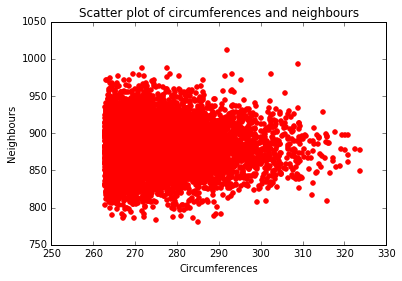

In [561]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(circum_neighbours.keys().collect(),circum_neighbours.values().collect(), label='skitscat', color='r')

plt.xlabel('Circumferences')
plt.ylabel('Neighbours')
plt.title('Scatter plot of circumferences and neighbours')
plt.show()

In [558]:
### END OF ASSIGNMENT 1 ###